# Print the results


In [1]:
%matplotlib inline

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

import sys
__file__ = '012-prerpocessing.ipynb'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.evaluation

### Configuration

In [3]:
from config import config_vars

config_vars["root_directory"] = '../DATA/FISH'

In [5]:
# Partition of the data to make predictions (test or validation)
partition = "validation"

experiment_name = '00'

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

In [6]:
data_partitions = utils.dirtools.read_data_partitions(config_vars)

In [ ]:
# To evaluate segmentations produced by other segmentation algorithms (e.g. CellProfiler), 
# manually modify the following config var:

#config_vars["labels_out_dir"] = "/data/cellprofiler_segmentations/"
#config_vars["object_dilation"] = 2

#### show the comparison between norm_image, raw_annot and label_out

In [ ]:
import matplotlib as mpl
mpl.rcParams["image.cmap"] # default to viridis

In [ ]:
mpl.rcParams["image.cmap"] = 'viridis'

In [10]:
img_name = "0000.png"
pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
pred_label = skimage.io.imread(pred_label_filename)
pred_label = skimage.segmentation.relabel_sequential(pred_label)[0]

inc = lambda x: x if x == 0 else x + 100
inc = np.vectorize(inc)  # this is implemented by for loop
pred_label = inc(pred_label)
print(type(pred_label))
pred_label.min()

<class 'numpy.ndarray'>


0

#### Remove Border Nuclei

In [11]:
img_name = "0000.png"
pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
pred_label = skimage.io.imread(pred_label_filename)
pred_label = skimage.segmentation.relabel_sequential(pred_label)[0]
print(pred_label.max(), pred_label.min(), pred_label.shape, type(pred_label))

66 0 (512, 512) <class 'numpy.ndarray'>


In [12]:
out = pred_label.copy()
out = out.ravel()
component_sizes = np.bincount(out)
print(type(component_sizes), component_sizes.shape)
print(component_sizes)

<class 'numpy.ndarray'> (67,)
[226027    685    633    522    664    789    497    581    424    651
    121     38    244    622     79    397    745    767    610     77
    418    552    557    958    598     47    715    921    625    445
    106    536    549    697    643    554    692    565    584    242
    757    461    567    732    594    629    682    601    489    519
    656    626    693    735    777    124    406    471    491    451
    575    712    880    431    829    722    357]


In [13]:
out = pred_label.copy()
out = out.ravel()
component_sizes = np.bincount(out)
print(type(component_sizes), component_sizes.shape)
print(component_sizes)

<class 'numpy.ndarray'> (67,)
[226027    685    633    522    664    789    497    581    424    651
    121     38    244    622     79    397    745    767    610     77
    418    552    557    958    598     47    715    921    625    445
    106    536    549    697    643    554    692    565    584    242
    757    461    567    732    594    629    682    601    489    519
    656    626    693    735    777    124    406    471    491    451
    575    712    880    431    829    722    357]


In [7]:
def remove(pred_label, cb):
    # how to use filter to constrain not removing big nucleus
    out = pred_label.copy()
    out_f = out.ravel()  # flatten out
    component_sizes = np.bincount(out_f)
    cb_ = cb
#     cb_ = []
#     for c in cb:
#         if component_sizes[c] < 400:  # 357 this should be larger???
#             cb_.append(c)
            
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            for c in cb_:
                if out[i, j] == c:
                    out[i, j] = 0
    
    return out

In [8]:
def remove_border(pred_label):
    # find the classes of the partial nuclei which located on the border
    # traverse the border
    cb = set()
    for i in range(512):
        if pred_label[i, 0] != 0:
            cb.add(pred_label[i, 0])
        if pred_label[0, i] != 0:
            cb.add(pred_label[0, i])
        if pred_label[i, 511] != 0:
            cb.add(pred_label[i, 511])
        if pred_label[511, i] != 0:
            cb.add(pred_label[511, i])
    
    # change these classes to 0 as background
    # maybe I should add a constrain about not filtering the big cell
    return remove(pred_label, cb)

In [12]:
ppred_label = remove_border(pred_label)  # after post-processed

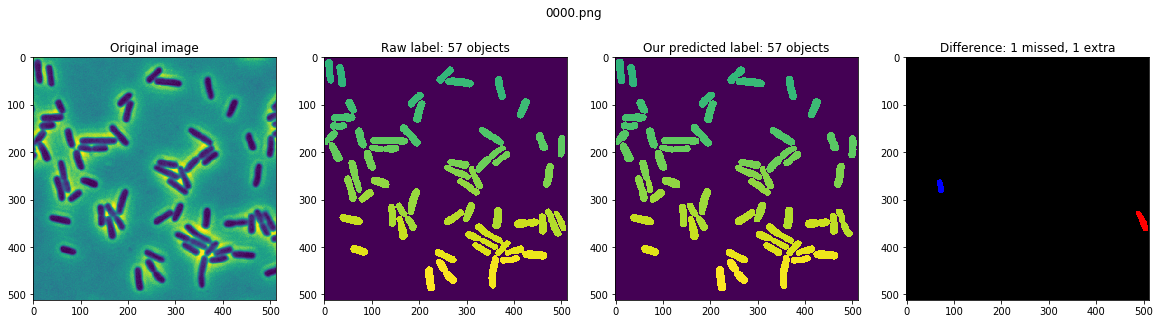

In [16]:
compare_2(img_name, ppred_label)

In [14]:
def compare_2(img_name, pred_label):
    ori_img_filename = os.path.join(config_vars["normalized_images_dir"], img_name)
    original_image = skimage.io.imread(ori_img_filename)
    annot_filename = os.path.join(config_vars["raw_annotations_dir"], img_name)
    raw_label = skimage.io.imread(annot_filename)
#     pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
#     pred_label = skimage.io.imread(pred_label_filename)

    raw_label = skimage.morphology.label(raw_label)
    raw_label = skimage.segmentation.relabel_sequential(raw_label)[0] #[30:-30,30:-30])[0]
    
    struct = skimage.morphology.square(config_vars["object_dilation"])
    pred_label = skimage.morphology.dilation(pred_label, struct)
    pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
    
    diff, missed, extra = difference(raw_label, pred_label)
        
    # make graph easier to look
    inc = lambda x: x if x == 0 else x + 100
    inc = np.vectorize(inc)
    raw_label = inc(raw_label)
    pred_label = inc(pred_label)
        
    fig, ax = plt.subplots(1, 4, figsize=(20,5))
    fig.suptitle(img_name)
    ax[0].set_title("Original image")
    ax[0].imshow(original_image)
    ax[1].set_title("Raw label: " + str(len(np.unique(raw_label))) + " objects")
    ax[1].imshow(raw_label)
    ax[2].set_title("Our predicted label: " + str(len(np.unique(pred_label))) + " objects")
    ax[2].imshow(pred_label)
    ax[3].imshow(diff)
    ax[3].set_title("Difference: " + missed + ' missed, ' + extra + ' extra')

In [15]:
def difference(raw_label, pred_label):
    ground_truth = raw_label.copy()
    prediction = pred_label.copy()
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    threshold = 0.5  # if set to 0.8, more misses will appear, but 0.5 no miss
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis = 1) == 0)[0]  # for original cell, none predict cell match 
    extra = np.where(np.sum(C, axis = 0) == 0)[0]  # for predict cell, none original cell match

    for m in missed:
        diff[ground_truth == m + 1, 0] = 1
    for e in extra:
        diff[prediction == e + 1, 2] = 1
        
    return diff, str(len(missed)), str(len(extra))

In [18]:
def compare(img_name):
    ori_img_filename = os.path.join(config_vars["normalized_images_dir"], img_name)
    original_image = skimage.io.imread(ori_img_filename)
    annot_filename = os.path.join(config_vars["raw_annotations_dir"], img_name)
    raw_label = skimage.io.imread(annot_filename)
    pred_label_filename = os.path.join(config_vars["labels_out_dir"], img_name)
    pred_label = skimage.io.imread(pred_label_filename)

    ppred_label = remove_border(pred_label)  # after post-processed
    
    raw_label = skimage.morphology.label(raw_label)
    raw_label = skimage.segmentation.relabel_sequential(raw_label)[0] #[30:-30,30:-30])[0]
    
    struct = skimage.morphology.square(config_vars["object_dilation"])
    pred_label = skimage.morphology.dilation(pred_label, struct)
    pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
    
    ppred_label = skimage.morphology.dilation(ppred_label, struct)
    ppred_label = skimage.segmentation.relabel_sequential(ppred_label)[0] #[30:-30,30:-30])[0]
    
    diff, missed, extra = difference(raw_label, pred_label)
    diff2, missed2, extra2 = difference(raw_label, ppred_label)
        
    # make graph easier to look
    inc = lambda x: x if x == 0 else x + 100
    inc = np.vectorize(inc)
    raw_label = inc(raw_label)
    pred_label = inc(pred_label)
    ppred_label = inc(ppred_label)
        
    fig, ax = plt.subplots(2, 4, figsize=(14,5))
    fig.suptitle(img_name)
    ax[0][0].set_title("Original image")
    ax[0][0].imshow(original_image)
    ax[0][1].set_title("Raw label: " + str(len(np.unique(raw_label))) + " objects")
    ax[0][1].imshow(raw_label)
    ax[0][2].set_title("Our predicted label: " + str(len(np.unique(pred_label))) + " objects")
    ax[0][2].imshow(pred_label)
    ax[0][3].set_title("Difference: " + missed + ' missed, ' + extra + ' extra')
    ax[0][3].imshow(diff)
    
#     ax[1][0].set_title("Original image")
    ax[1][0].imshow(original_image)
#     ax[1][1].set_title("Raw label: " + str(len(np.unique(raw_label))) + " objects")
    ax[1][1].imshow(raw_label)
    ax[1][2].imshow(ppred_label)
    ax[1][2].set_title("After post-processed border: " + str(len(np.unique(ppred_label))) + 
                       " objects", y=1.08)
    ax[1][3].imshow(diff2)
    ax[1][3].set_title("Difference: " + missed2 + ' missed, ' + extra2 + ' extra', y=1.08)
    plt.tight_layout()  # make title not overlap
    


    # plt.figure(figsize=(6,6))
    # plt.imshow(original_image)  #, cmap="nipy_spectral")
    # plt.show()

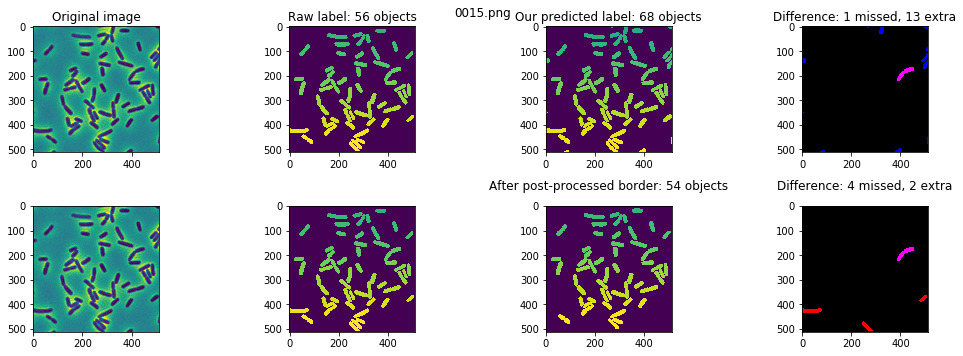

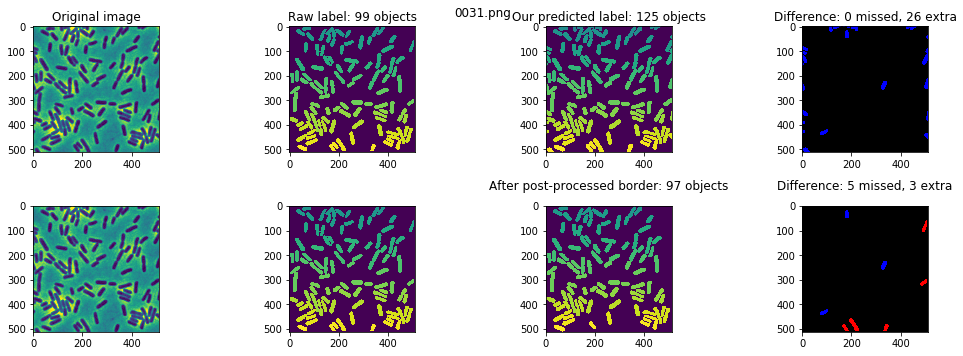

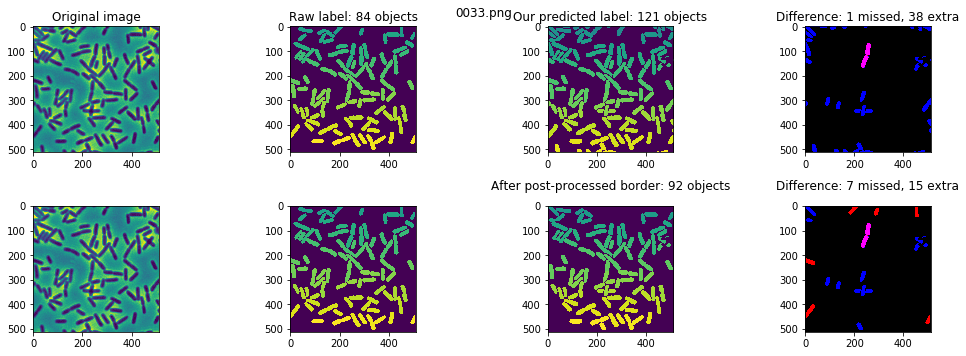

In [20]:
for i in np.random.randint(48, size = 3):
    img = "{:04}".format(i) + ".png"
    compare(img)